# Predicting Stock Price Movement and Volatility using Multimodal & Multitask Deep Learning  

#### Multimodal: 
Using price data and stock data as two inputs in two separate LSTMs and then concatenating them to form the model
#### Multitask: 
Predicting Volatility (continuous measure) and Price Movement Direction (discrete: up or down) using a single model

#### Datasets used:
##### 1. News Data 
Crawled Historical News Headlines from Reddit WorldNews Channel. It has top 25 headlines for each date from August 2008 to July 2016, i.e 8 years.
##### 2. Stock Data
Dow Jones Industrial Average (DJIA) OHLCV (Open, High, Low, Close, Volume) tuple for each trading day from August 2008 to July 2016.

#### Import
Importing the required libraries as well as preprocessing code.

In [1]:
%matplotlib inline
from process_data import *
from keras.models import Sequential
from keras.models import Model
from keras.layers.core import Dense, Dropout, Activation, Flatten, Permute
from keras.layers import Merge, Input, concatenate, average, add
from keras.layers.recurrent import LSTM, GRU
from keras.layers import Convolution1D, MaxPooling1D, AtrousConvolution1D, RepeatVector, AveragePooling1D
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, CSVLogger
from keras.layers.wrappers import Bidirectional, TimeDistributed
from keras import regularizers
from keras.layers.normalization import BatchNormalization
from keras.layers.advanced_activations import *
from keras.optimizers import RMSprop, Adam, SGD, Nadam
from keras.initializers import *
from keras.constraints import *
from keras import regularizers
from keras import losses
import matplotlib.pyplot as plt
from sklearn import svm, datasets
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix

Using Theano backend.


#### Load Data
Loading the price & news data and splitting each into test & training set. The sentences are converted to lists vectors of 100 dimensions using Google Word2Vec. Variables used are:

X_train : Time series data

X_train_text : word2vec decoded text data

Y_train : Labels for voaltility

Y_train2 : Labels for classification (movement direction)

In [2]:
train, test = load_text_csv()
data_chng_train, data_chng_test = load_ts_csv()

train_text = cPickle.load(open('train_text.p', 'rb'))[1:]
test_text = cPickle.load(open('test_text.p', 'rb'))[1:]

train_text_vectors, test_text_vectors, model = transform_text_into_vectors(train_text, test_text, 100)

X_train, X_train_text, Y_train, Y_train2 = split_into_XY(data_chng_train, train_text_vectors, 1, 30, 1)
X_test, X_test_text, Y_test, Y_test2 = split_into_XY(data_chng_test, test_text_vectors, 1, 30, 1)


X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 5))
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 5))


(1611, 5)
(378, 5)
KEK index 1611 is out of bounds for axis 0 with size 1611
KEK index 378 is out of bounds for axis 0 with size 378


#### Model Design
The model is made by concatenating two LSTMs, one (lstm1) takes OHLCV tuple as input and the other (lstm2) takes vector representation of news data. The two outputs of the model are volatility (standard deviation - x1) and price movement direction (up or down - x2)

In [3]:
main_input = Input(shape=(30, 5), name='ts_input')
text_input = Input(shape=(30, 100), name='text_input')
lstm1 = LSTM(10, return_sequences=True, recurrent_dropout=0.25, dropout=0.25, bias_initializer='ones')(main_input)
lstm1 = LSTM(10, return_sequences=True, recurrent_dropout=0.25, dropout=0.25, bias_initializer='ones')(lstm1)
lstm1 = Flatten()(lstm1)
lstm2 = LSTM(10, return_sequences=True, recurrent_dropout=0.25, dropout=0.25, bias_initializer='ones')(text_input)
lstm2 = LSTM(10, return_sequences=True, recurrent_dropout=0.25, dropout=0.25, bias_initializer='ones')(lstm2)
lstm2 = Flatten()(lstm2)


lstms = concatenate([lstm1, lstm2])


x1 = Dense(64)(lstms)
x1 = LeakyReLU()(x1)
x1 = Dense(1, activation = 'linear', name='regression')(x1)

x2 = Dense(64)(lstms)
x2 = LeakyReLU()(x2)
x2 = Dropout(0.9)(x2)
x2 = Dense(1, activation = 'sigmoid', name = 'class')(x2)

final_model = Model(inputs=[main_input, text_input], 
              outputs=[x1, x2])

#### Training the Model
Training parameter like loss, optimizer & learning rate are set as below.. Volatility error is measured using MSE & price movement direction by Binary Crossentropy.

In [4]:
opt = Nadam(lr=0.002, clipnorm = 0.5)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.9, patience=50, min_lr=0.000001, verbose=1)
checkpointer = ModelCheckpoint(monitor='val_loss', filepath="model.hdf5", verbose=1, save_best_only=True)
final_model.compile(optimizer=opt, loss={'regression': 'mse', 'class': 'binary_crossentropy'}, loss_weights=[1., 0.2])

The training is performed for 100 epochs over the dataset with a batchsize of 100.

In [5]:
history = final_model.fit([X_train, X_train_text], [Y_train, Y_train2],
		nb_epoch = 100, 
		batch_size = 256, 
		verbose=1, 
		validation_data=([X_test, X_test_text], [Y_test, Y_test2]), 
		callbacks=[reduce_lr, checkpointer], shuffle=True)

/home/amitoj/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:6: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.
WARNING (theano.configdefaults): install mkl with `conda install mkl-service`: No module named mkl


Train on 1580 samples, validate on 347 samples
Epoch 1/100
1580/1580 [==============================] - 1s - loss: 2.8988 - regression_loss: 2.7138 - class_loss: 0.9249 - val_loss: 1.3776 - val_regression_loss: 1.2325 - val_class_loss: 0.7254
Epoch 2/100
1580/1580 [==============================] - 1s - loss: 0.8122 - regression_loss: 0.6535 - class_loss: 0.7935 - val_loss: 0.1795 - val_regression_loss: 0.0153 - val_class_loss: 0.8210
Epoch 3/100
1580/1580 [==============================] - 1s - loss: 0.6623 - regression_loss: 0.4607 - class_loss: 1.0081 - val_loss: 0.9434 - val_regression_loss: 0.8032 - val_class_loss: 0.7009
Epoch 4/100
1580/1580 [==============================] - 1s - loss: 0.5524 - regression_loss: 0.3948 - class_loss: 0.7876 - val_loss: 0.1630 - val_regression_loss: 0.0242 - val_class_loss: 0.6938
Epoch 5/100
1580/1580 [==============================] - 1s - loss: 0.4670 - regression_loss: 0.3132 - class_loss: 0.7693 - val_loss: 0.5981 - val_regression_loss: 0.456

#### Evaluation
The below graph shows how the overall training & test losses decreased during training. 

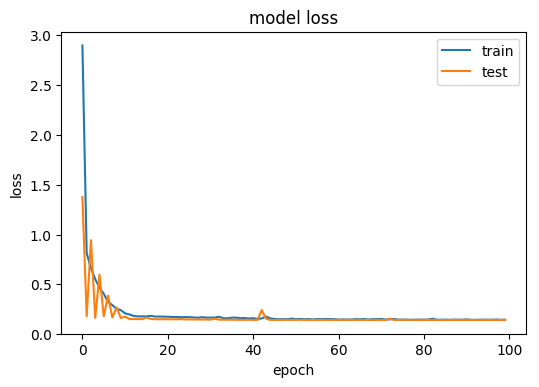

In [6]:
plt.figure()
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='best')
plt.show()

Predictions of volatility are shown in blue while the actual volatility is in black. The model is very effective in capturing drastic changes in volatility. Note that these values are normalized (between 0 & 1).

WARNING (theano.configdefaults): install mkl with `conda install mkl-service`: No module named mkl
/home/amitoj/anaconda2/lib/python2.7/site-packages/matplotlib/axes/_axes.py:545: UserWarning: No labelled objects found. Use label='...' kwarg on individual plots.
  warnings.warn("No labelled objects found. "


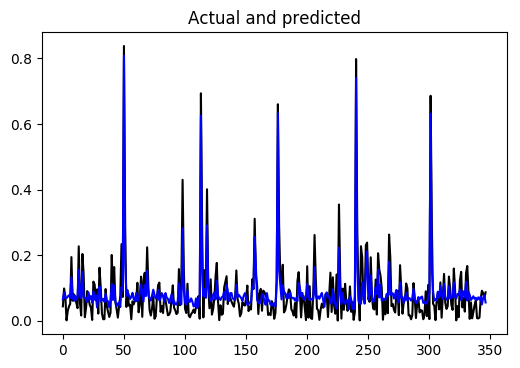

0.0171427005365
0.0708852836538
3.15806185535


In [4]:
final_model.load_weights("model.hdf5")
pred = final_model.predict([X_test, X_test_text])[0]

predicted = pred
original = Y_test

plt.title('Actual and predicted')
plt.legend(loc='best')
plt.plot(original, color='black', label = 'Original data')
plt.plot(pred, color='blue', label = 'Predicted data')
plt.show()
print np.mean(np.square(predicted - original))
print np.mean(np.abs(predicted - original))
print np.mean(np.abs((original - predicted) / original))

In [5]:
preds = final_model.predict([X_test, X_test_text])[1]

In [7]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
  
    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    return cm

[[107  65]
 [ 49 126]]


NameError: global name 'itertools' is not defined

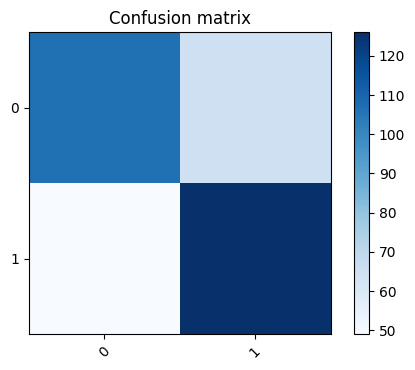

In [8]:
cnf_matrix = plot_confusion_matrix(cm, [0, 1])
cnf_matrix
print cnf_matrix